
# Linear regression example using Spike-Slab Prior

The model equation is y = ax + b with a, b being the model parameters, while the
likelihood model is based on a normal zero-mean additive model error distribution. The problem is solved via sampling using emcee.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

We start by generating a synthetic data set from a known linear model to which we will
add some noise.



In [2]:
# ground truth that is to be inferred
a_true = 8
b_true = 10

# settings for data generation
n_tests = 50
seed = 1
mean_noise = 0.0
std_noise = 1 # is assumed to be known and is not inferred.

# generate the data
np.random.seed(seed)
x_test = np.linspace(-4.0, 4.0, n_tests)
y_true = a_true * x_test + b_true #a_true * x_test**2 #+ b_true * x_test + c_true #a_true * x_test**2 + 
y_test = y_true + np.random.normal(loc=mean_noise, scale=std_noise, size=n_tests)

Let's take a look at the data that we just generated:



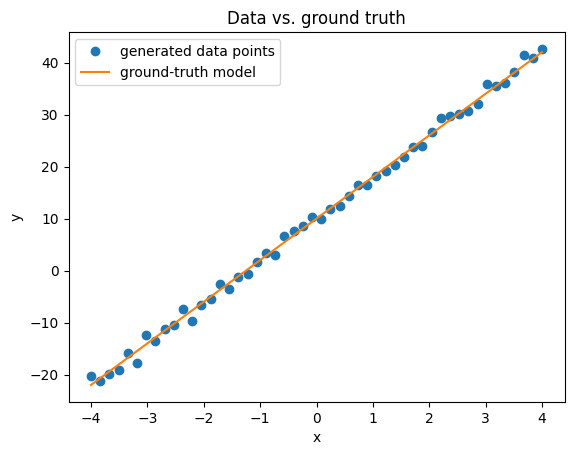

In [3]:
plt.plot(x_test, y_test, "o", label="generated data points")
plt.plot(x_test, y_true, label="ground-truth model")
#plt.plot(x_test, - 2*x_test , label="ground-truth model") #1*np.exp(x_test)
plt.title("Data vs. ground truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Starting values for the parameters are selected using priors. Parameters.json file contatins the list of parameters and their definition.



In [4]:
import json
with open('parameters_bernoulli_hyperprior.json', 'r') as f: 
    json_object = json.loads(f.read()) 

nwalkers = 20
ndim = len(json_object.get('parameters')) 
from scipy.stats import invgamma, halfcauchy, norm, bernoulli, uniform
start_parameters = np.zeros((nwalkers, ndim))
counter = 0

# This loop reads the parameters from the json file and samples from the prior distributions
for index, parameter in enumerate(json_object.get('parameters')):
    if parameter['prior'][0] == 'Bernoulli':
        start_parameters[:, index] = bernoulli.rvs(p = parameter['prior'][1]["p"], size=nwalkers)
    elif parameter['prior'][0] == 'Spike-Slab':
        for hyperparameter in parameter['hyperparameters']:
            for ind, param in enumerate(json_object.get('parameters')):
                if hyperparameter == param['name']:
                    lmbda = start_parameters[:, ind]
        start_parameters[:, index] = lmbda*norm.rvs(loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"], size=nwalkers) 
    elif parameter['prior'][0] == 'Normal': 
        start_parameters[:, index] = norm.rvs(loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"], size=nwalkers) 
    elif parameter['prior'][0] == 'Uniform':   
        start_parameters[:, index] = uniform.rvs(loc = parameter['prior'][1]["lower_bound"], scale = parameter['prior'][1]["lower_bound"] + parameter['prior'][1]["upper_bound"], size=nwalkers)   


Defining the log likelihood, log prior functions and using emcee to run the inference problem.

In [5]:
def log_likelihood(theta, _x_test, _y_test, _sigma):

    y_model = theta[1] * _x_test  + theta[3] + theta[5] * np.square(_x_test) 

    return -0.5 * np.sum((_y_test - y_model) ** 2 / _sigma**2 + np.log(_sigma**2))

def log_prior(theta):
    _lp = 0
    # This loop reads the parameters from the json file and calulates the log prior.
    for index, parameter in enumerate(json_object.get('parameters')):
        if parameter['prior'][0] == 'Bernoulli':
            ## Uncomment the following lines to see the change in trace of the Bernoulli parameters.
            #if theta[index] >= 0.3:
            #    theta[index] = 1
            #else:
            #    theta[index] = 0
            if theta[index] < 0.0 or theta[index] > 1.0:
                return -np.inf
            _lp += bernoulli.logpmf(0 if theta[index] < 0.5 else 1, p = parameter['prior'][1]["p"])            
            #_lp += bernoulli.logpmf(theta[index], p = parameter['prior'][1]["p"])
        elif parameter['prior'][0] == 'Spike-Slab':
            for hyperparameter in parameter['hyperparameters']:
                for ind, param in enumerate(json_object.get('parameters')):
                    if hyperparameter == param['name']:
                        lmbda = theta[ind]
            if lmbda >= 0.5:
                _lp += norm.logpdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"])
            elif lmbda < 0.5:
                theta[index] = 0
                #_lp += 0
        
        elif parameter['prior'][0] == 'Normal': 
            _lp += norm.logpdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"]) 

        elif parameter['prior'][0] == 'Uniform':   
            _lp += uniform.logpdf(theta[index], loc = parameter['prior'][1]["lower_bound"], scale = parameter['prior'][1]["lower_bound"] + parameter['prior'][1]["upper_bound"])    
    
    return _lp
            

def log_probability(theta, _x_test, _y_test, _std_noise):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, _x_test, _y_test, _std_noise)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x_test, y_test, std_noise))
sampler.run_mcmc(start_parameters, 3000, progress=True)

100%|██████████| 3000/3000 [00:15<00:00, 190.84it/s]


State([[ 0.96535219  8.04713244  0.50470565 10.14303663  0.47507524  0.        ]
 [ 0.50931746  8.14495317  0.82931308 10.02328114  0.19186832  0.        ]
 [ 0.74335442  8.03213764  0.73653346  9.82082769  0.23945391  0.        ]
 [ 0.66798719  8.09254817  0.64314302  9.74637779  0.76015848  0.        ]
 [ 0.70567402  8.17047838  0.77827136  9.9773159   0.03097943  0.        ]
 [ 0.81429632  8.18102411  0.7127412   9.80690329  0.42916572  0.        ]
 [ 0.76334863  7.95298079  0.68036479  9.71117118  0.0650612   0.        ]
 [ 0.82386171  8.10810831  0.87716091 10.09898552  0.33937531  0.        ]
 [ 0.65553731  8.12395065  0.64803416 10.19261501  0.5344365   0.        ]
 [ 0.69387229  7.96383285  0.75894251  9.98579546  0.1138322   0.        ]
 [ 0.9740635   7.96132656  0.97088231 10.0932174   0.25887845  0.        ]
 [ 0.54471192  8.00779019  0.86989861 10.02475021  0.1469611   0.        ]
 [ 0.59355657  8.06251274  0.60589815  9.9866977   0.35805279  0.        ]
 [ 0.84317258  8.12

Plotting the trace of the chain

Text(0.5, 0, 'step number')

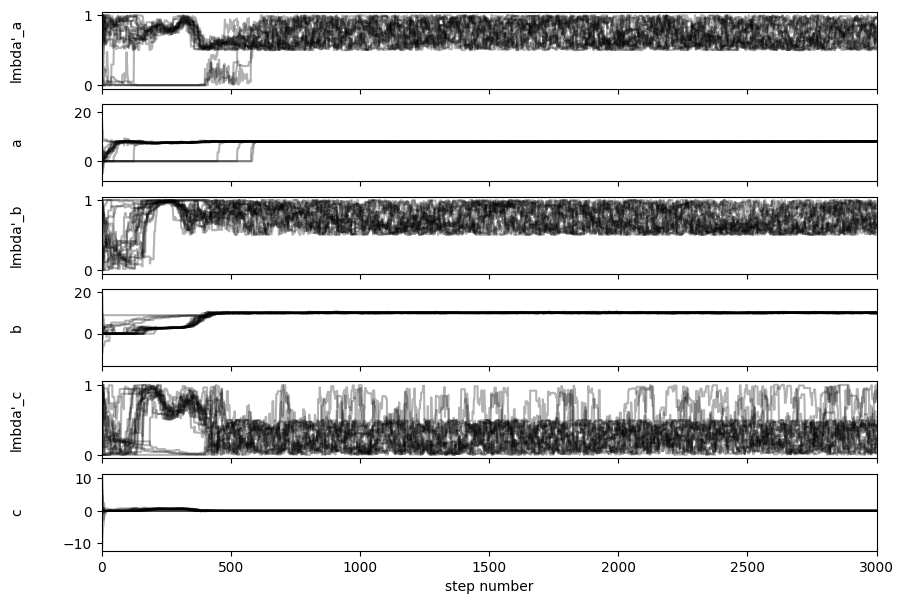

In [9]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["lmbda'_a", "a", "lmbda'_b", "b", "lmbda'_c", "c"] # Change the labels over here if changes in parameters are made in json file.
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

Plotting the pair-plot of the chain.

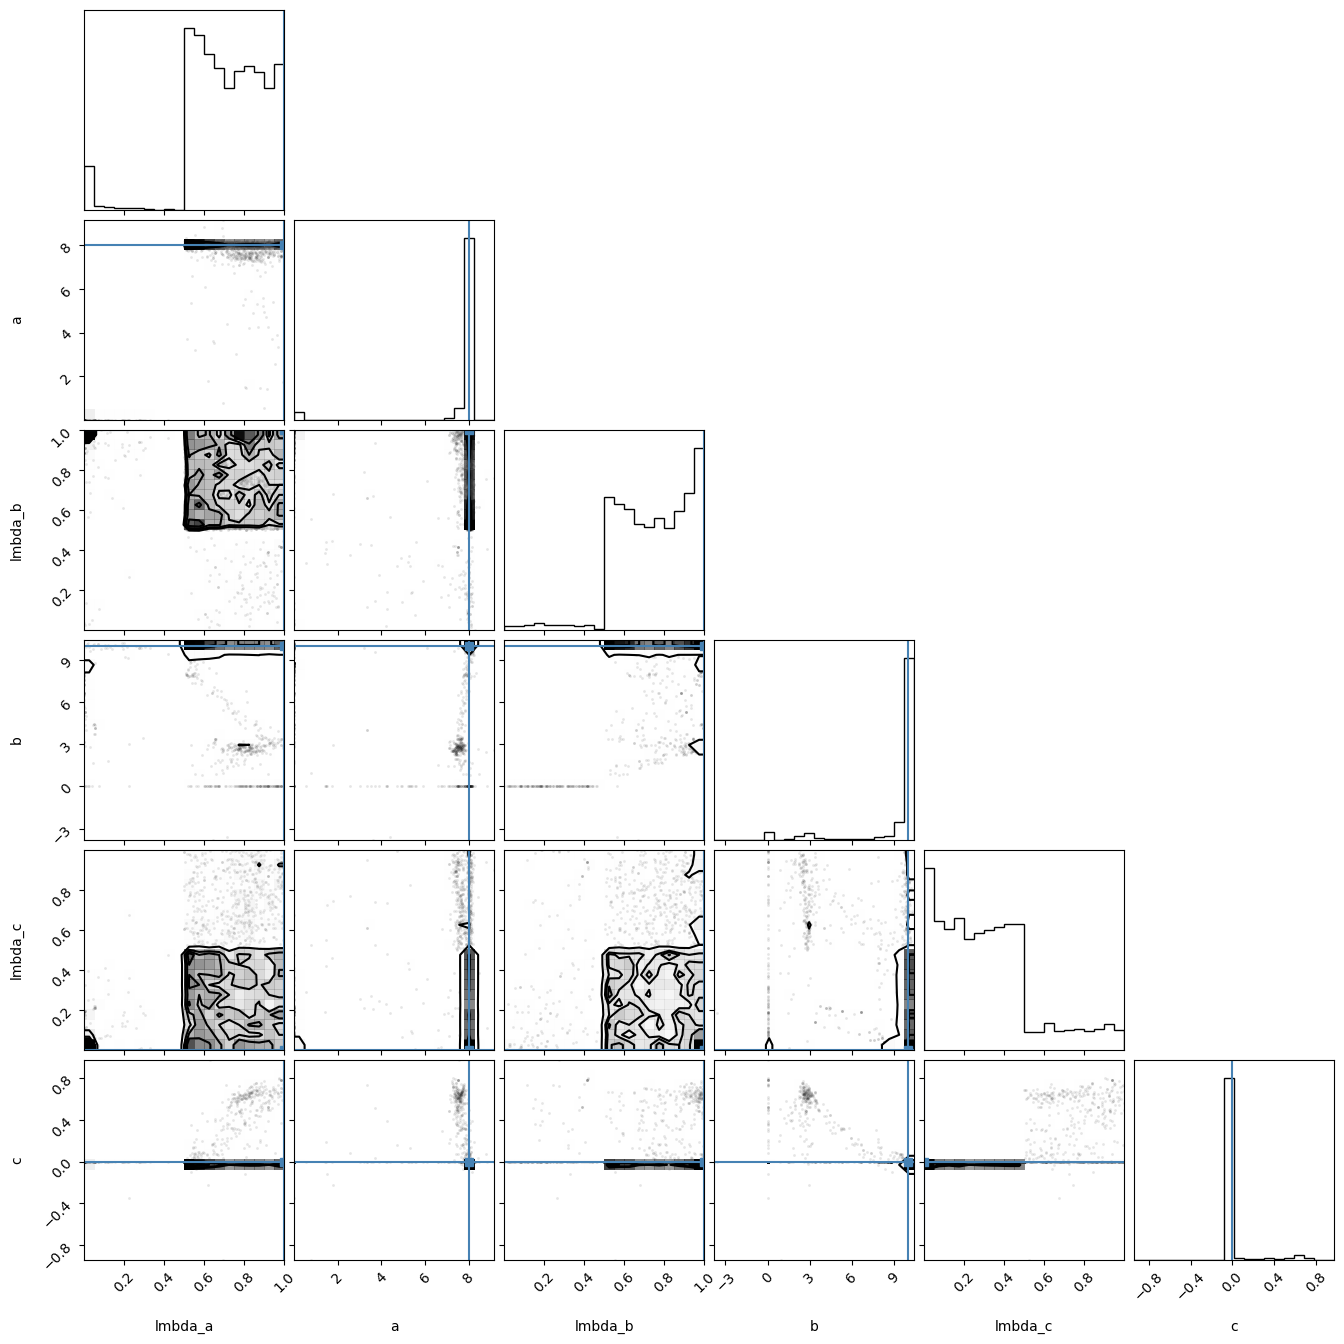

In [13]:
flat_samples = sampler.get_chain(discard=0, thin=15, flat=True)
import corner
fig = corner.corner(
    flat_samples, labels=labels, truths=[1, 8, 1, 10, 0, 0]
)